

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-08-18 03:28:18,170: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/results.json


In [5]:
params.use_data_augmentation

True

## Get Data

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

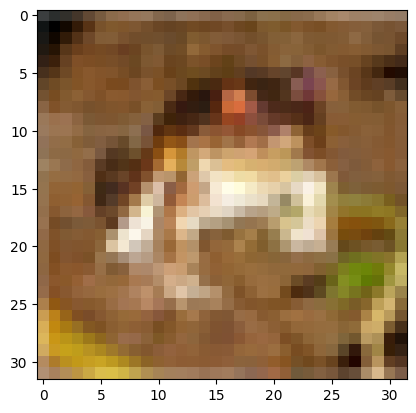

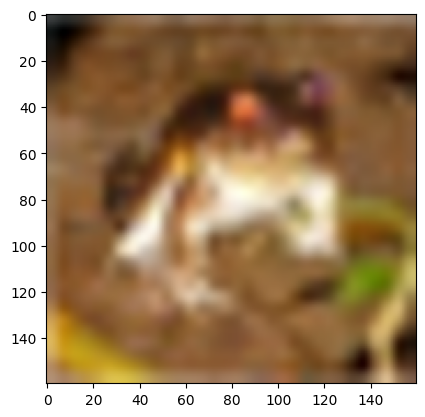

(32, 32, 3) (160, 160, 3)


In [8]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [9]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

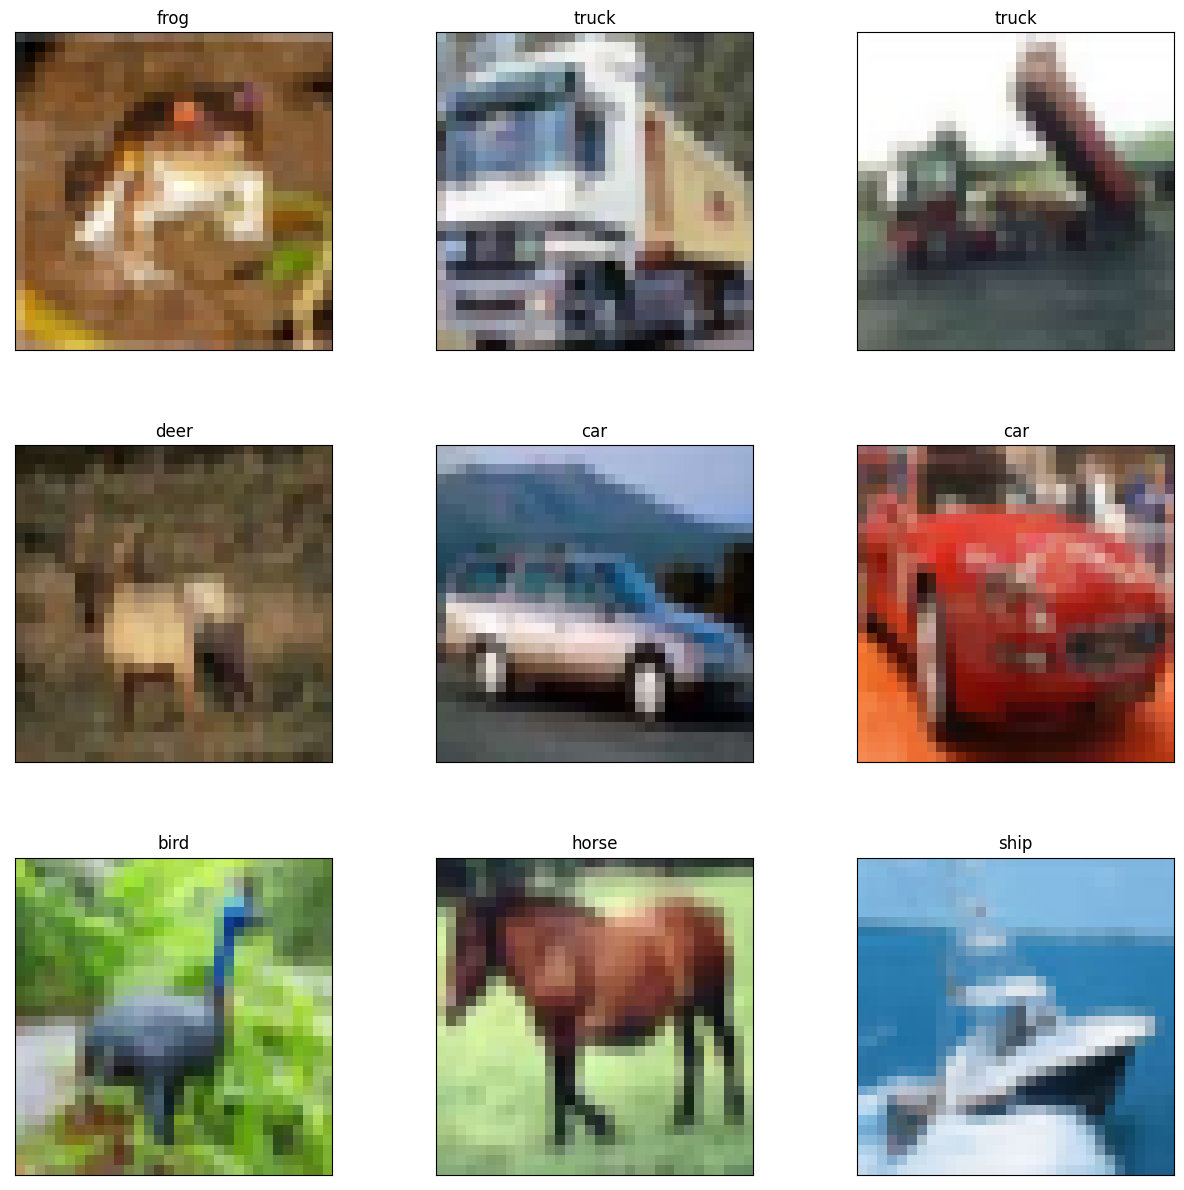

In [10]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

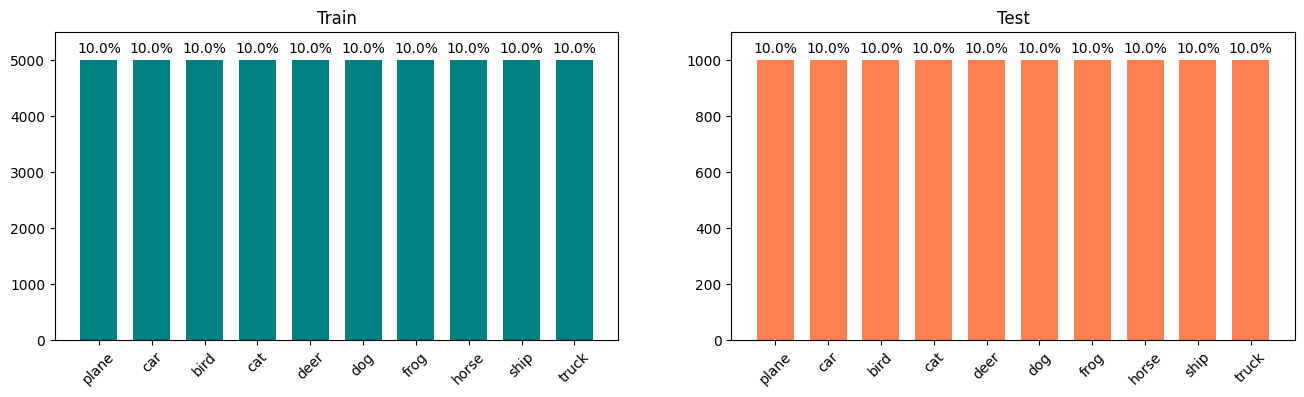

In [11]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [12]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [13]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [14]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

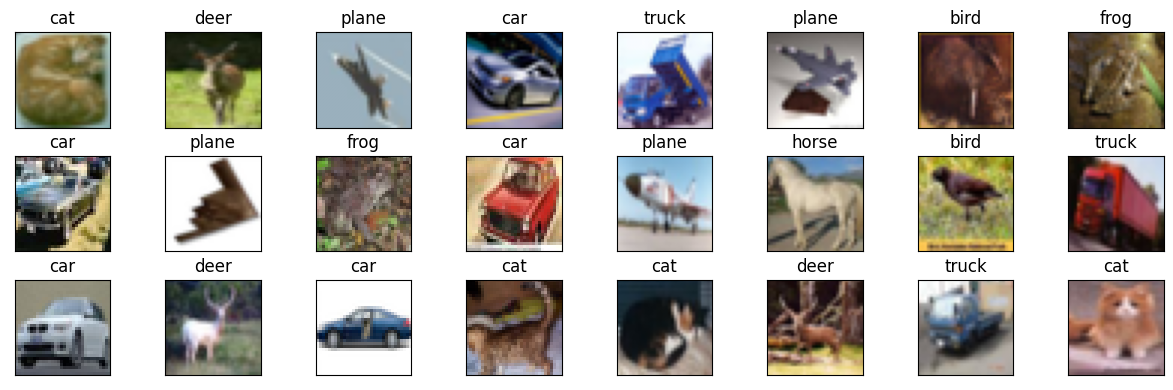

In [15]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [16]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

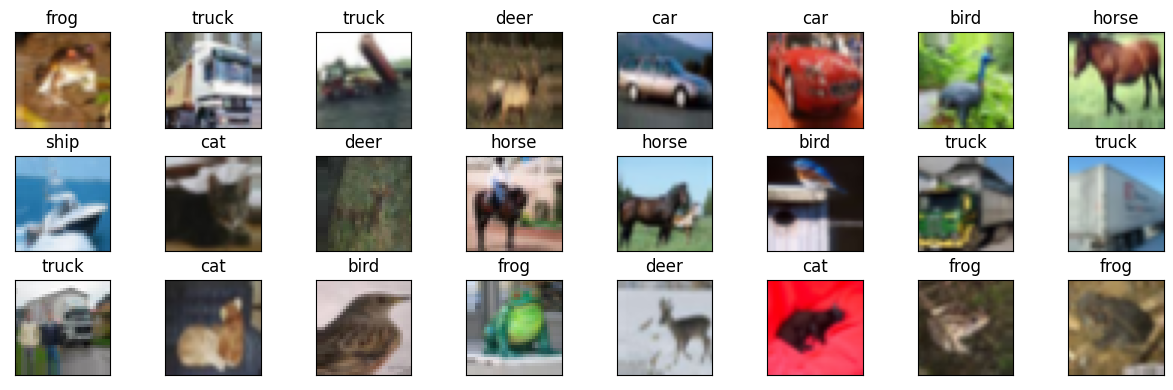

In [17]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

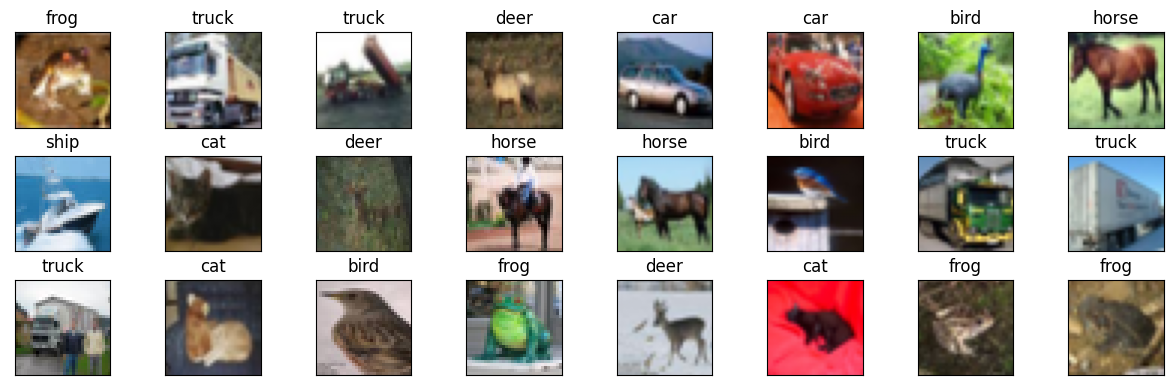

In [18]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [19]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [23]:
# print(f'use_data_augmentation = {params.use_data_augmentation}')
# if params.use_data_augmentation:
#     datasets = augment_datasets
# else:
datasets = raw_datasets

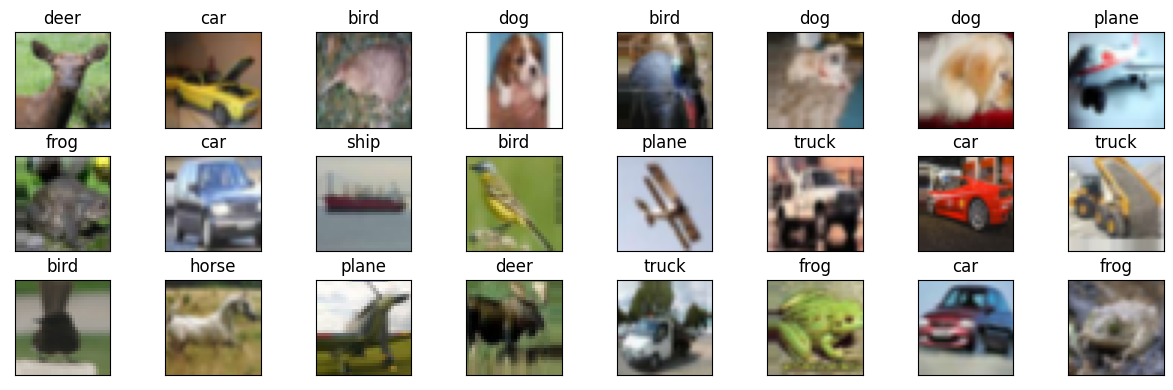

In [21]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


(32, 32, 3) <dtype: 'uint8'> <class 'tensorflow.python.framework.ops.EagerTensor'>


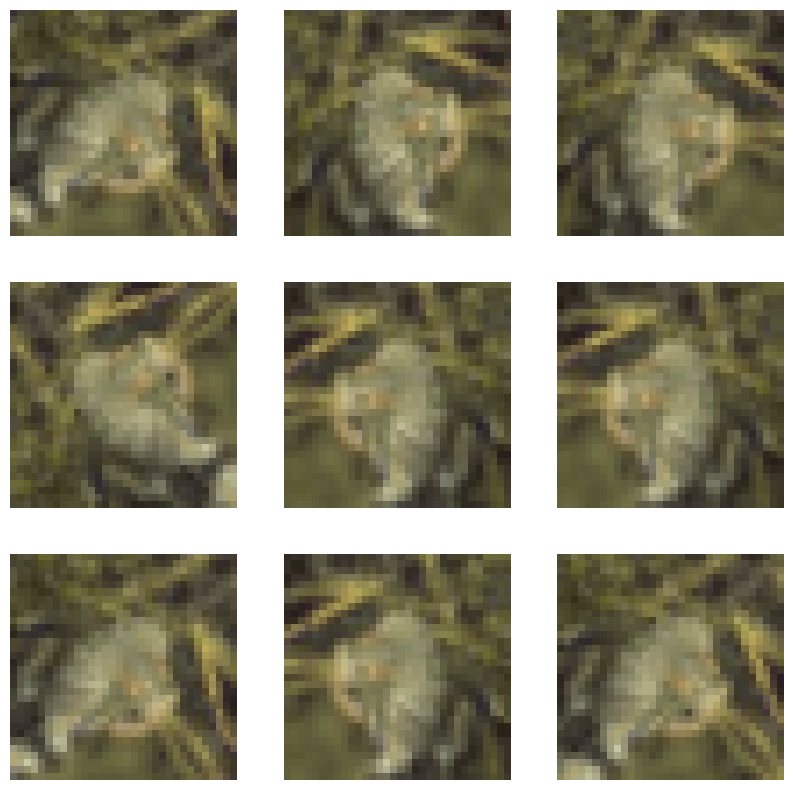

In [27]:
augmented_images = []
for image, _ in datasets.train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    print(first_image.shape, first_image.dtype, type(first_image)) 

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
        augmented_images.append(augmented_image) 
plt.show() 

In [28]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

In [29]:
if params.use_data_augmentation:
    preprocess_fun = [data_augmentation, rescale]
else:
    preprocess_fun = rescale
    
print(preprocess_fun)

[<keras.engine.sequential.Sequential object at 0x7fe120286130>, <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fe120113220>]




##  Models



### MLP

In [30]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=preprocess_fun)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

2022-08-17 04:35:11,435: INFO: model_params.mlp1.dropout=0.1
2022-08-17 04:35:11,436: INFO: model_params.mlp1.layer_count=1
2022-08-17 04:35:11,436: INFO: model_params.mlp1.units=128
2022-08-17 04:35:11,741: INFO: learning_rate=0.001
2022-08-17 04:35:11,742: INFO: model_params.mlp1.clip_value=None
2022-08-17 04:35:11,752: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290   

2022-08-17 04:35:11,768: INFO: model_params.mlp1.epochs=90
2022-08-17 04:35:11,769: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1, monitor=val_accuracy)
2022-08-17 04:35:11,769: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-17 04:35:11,770: INFO: use LearningRateScheduler()
2022-08-17 04:35:11,771: INFO: steps_per_epoch=1562
2022-08-17 04:35:11,771: INFO: start training
2022-08-17 04:35:11,772: INFO: use_class_weight=False


Epoch 1/90
1561/1562 [============================>.] - ETA: 0s - loss: 2.0486 - accuracy: 0.2387INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:35:42,900: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 31s 19ms/step - loss: 2.0485 - accuracy: 0.2387 - val_loss: 1.9140 - val_accuracy: 0.2837 - lr: 0.0010
Epoch 2/90
1561/1562 [============================>.] - ETA: 0s - loss: 1.9583 - accuracy: 0.2775INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:36:12,473: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.9582 - accuracy: 0.2775 - val_loss: 1.8723 - val_accuracy: 0.3049 - lr: 0.0010
Epoch 3/90
1561/1562 [============================>.] - ETA: 0s - loss: 1.9374 - accuracy: 0.2897INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:36:42,151: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.9373 - accuracy: 0.2897 - val_loss: 1.8459 - val_accuracy: 0.3202 - lr: 0.0010
Epoch 4/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.9216 - accuracy: 0.3009 - val_loss: 1.8678 - val_accuracy: 0.3123 - lr: 0.0010
Epoch 5/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.9098 - accuracy: 0.3057 - val_loss: 1.8495 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 6/90
1561/1562 [============================>.] - ETA: 0s - loss: 1.9099 - accuracy: 0.3078INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:38:06,872: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.9099 - accuracy: 0.3078 - val_loss: 1.8143 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 7/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.9026 - accuracy: 0.3095 - val_loss: 1.8275 - val_accuracy: 0.3294 - lr: 0.0010
Epoch 8/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.9019 - accuracy: 0.3112 - val_loss: 1.8123 - val_accuracy: 0.3334 - lr: 0.0010
Epoch 9/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8957 - accuracy: 0.3132 - val_loss: 1.8080 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 10/90
1562/1562 [==============================] - 27s 18ms/step - loss: 1.8967 - accuracy: 0.3160 - val_loss: 1.8186 - val_accuracy: 0.3335 - lr: 0.0010
Epoch 11/90
1562/1562 [==============================] - ETA: 0s - loss: 1.8912 - accuracy: 0.3155INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/ou

2022-08-17 04:40:27,064: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.8912 - accuracy: 0.3155 - val_loss: 1.8059 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 12/90
1561/1562 [============================>.] - ETA: 0s - loss: 1.8896 - accuracy: 0.3167INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:40:56,554: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 29s 19ms/step - loss: 1.8895 - accuracy: 0.3167 - val_loss: 1.7926 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 13/90
1562/1562 [==============================] - 27s 18ms/step - loss: 1.8884 - accuracy: 0.3171 - val_loss: 1.8103 - val_accuracy: 0.3382 - lr: 0.0010
Epoch 14/90
1562/1562 [==============================] - 27s 18ms/step - loss: 1.8862 - accuracy: 0.3171 - val_loss: 1.8041 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 15/90
1560/1562 [============================>.] - ETA: 0s - loss: 1.8807 - accuracy: 0.3220INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:42:21,329: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.8806 - accuracy: 0.3220 - val_loss: 1.7874 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 16/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8830 - accuracy: 0.3192 - val_loss: 1.7901 - val_accuracy: 0.3447 - lr: 0.0010
Epoch 17/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8802 - accuracy: 0.3199 - val_loss: 1.8027 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 18/90
1562/1562 [==============================] - ETA: 0s - loss: 1.8789 - accuracy: 0.3221INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:43:46,001: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.8789 - accuracy: 0.3221 - val_loss: 1.7855 - val_accuracy: 0.3474 - lr: 0.0010
Epoch 19/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8774 - accuracy: 0.3204 - val_loss: 1.7913 - val_accuracy: 0.3430 - lr: 0.0010
Epoch 20/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8753 - accuracy: 0.3245 - val_loss: 1.7888 - val_accuracy: 0.3398 - lr: 0.0010
Epoch 21/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8743 - accuracy: 0.3239 - val_loss: 1.7910 - val_accuracy: 0.3404 - lr: 0.0010
Epoch 22/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8751 - accuracy: 0.3227 - val_loss: 1.7919 - val_accuracy: 0.3406 - lr: 0.0010
Epoch 23/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8733 - accuracy: 0.3269 - val_loss: 1.8139 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 24/90
1562/1562 [=============================

2022-08-17 04:49:19,125: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.8705 - accuracy: 0.3266 - val_loss: 1.7838 - val_accuracy: 0.3479 - lr: 0.0010
Epoch 31/90
1562/1562 [==============================] - ETA: 0s - loss: 1.8729 - accuracy: 0.3229INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:49:49,769: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 31s 20ms/step - loss: 1.8729 - accuracy: 0.3229 - val_loss: 1.7786 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 32/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8683 - accuracy: 0.3258 - val_loss: 1.7930 - val_accuracy: 0.3394 - lr: 0.0010
Epoch 33/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8694 - accuracy: 0.3259 - val_loss: 1.7957 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 34/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8649 - accuracy: 0.3289 - val_loss: 1.7782 - val_accuracy: 0.3480 - lr: 0.0010
Epoch 35/90
1561/1562 [============================>.] - ETA: 0s - loss: 1.8632 - accuracy: 0.3281INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


2022-08-17 04:51:45,518: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.8631 - accuracy: 0.3281 - val_loss: 1.7749 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 36/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8646 - accuracy: 0.3282 - val_loss: 1.7807 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 37/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8618 - accuracy: 0.3270 - val_loss: 1.7806 - val_accuracy: 0.3508 - lr: 0.0010
Epoch 38/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8638 - accuracy: 0.3281 - val_loss: 1.7841 - val_accuracy: 0.3428 - lr: 0.0010
Epoch 39/90
1562/1562 [==============================] - 28s 18ms/step - loss: 1.8646 - accuracy: 0.3269 - val_loss: 1.7716 - val_accuracy: 0.3529 - lr: 0.0010
Epoch 40/90
1562/1562 [==============================] - ETA: 0s - loss: 1.8684 - accuracy: 0.3240INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification

2022-08-17 04:54:08,232: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/mlp1/assets


1562/1562 [==============================] - 30s 19ms/step - loss: 1.8684 - accuracy: 0.3240 - val_loss: 1.7676 - val_accuracy: 0.3584 - lr: 0.0010
Epoch 41/90
1562/1562 [==============================] - 51s 32ms/step - loss: 1.8619 - accuracy: 0.3285 - val_loss: 1.7944 - val_accuracy: 0.3425 - lr: 0.0010
Epoch 42/90
 173/1562 [==>...........................] - ETA: 1:39 - loss: 1.8523 - accuracy: 0.3356

2022-08-17 04:55:11,434: INFO: finish training [elapsed time: 1199.66 seconds]


KeyboardInterrupt: 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=preprocess_fun)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [ ]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

In [ ]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=preprocess_fun)
model.summary()


In [ ]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=preprocess_fun)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [31]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [32]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [33]:
if params.use_data_augmentation:
    preprocess_fun = [data_augmentation, ResizeLayer(input_shape[:-1]), rescale1]
else:
    preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

print(preprocess_fun)

[<keras.engine.sequential.Sequential object at 0x7fe120286130>, <__main__.ResizeLayer object at 0x7fe0f845ab50>, <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fe0f8589340>]


(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


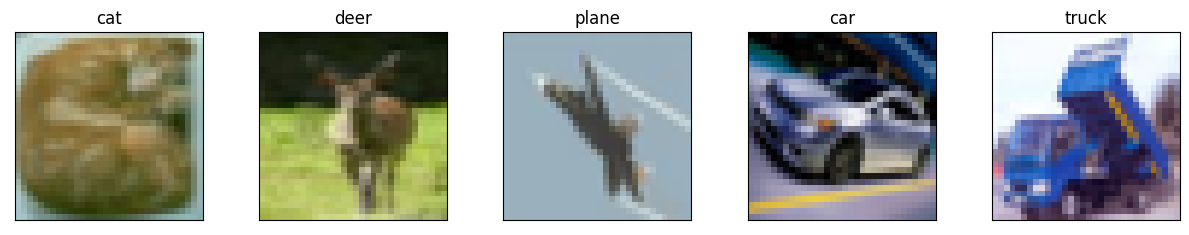

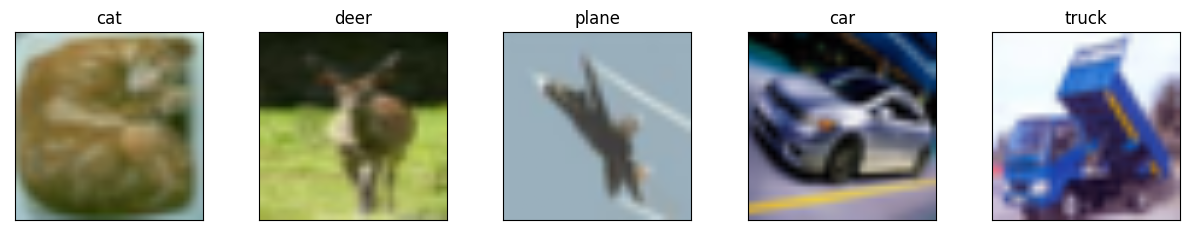

In [34]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [35]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [36]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [37]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-17 04:55:22,960: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-17 04:55:22,960: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-17 04:55:22,968: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAvera

2022-08-17 04:55:32,509: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 04:55:32,510: INFO: steps_per_epoch=1562
2022-08-17 04:55:32,511: INFO: start training
2022-08-17 04:55:32,511: INFO: use_class_weight=False


Epoch 1/10
1562/1562 [==============================] - ETA: 0s - loss: 1.5595 - accuracy: 0.4607

2022-08-17 04:57:58,800: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 04:58:03,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 152s 95ms/step - loss: 1.5595 - accuracy: 0.4607 - val_loss: 0.8008 - val_accuracy: 0.7385
Epoch 2/10
1562/1562 [==============================] - ETA: 0s - loss: 1.1085 - accuracy: 0.6133

2022-08-17 05:00:24,259: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:00:29,505: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 146s 93ms/step - loss: 1.1085 - accuracy: 0.6133 - val_loss: 0.6591 - val_accuracy: 0.7820
Epoch 3/10
1562/1562 [==============================] - ETA: 0s - loss: 1.0223 - accuracy: 0.6450

2022-08-17 05:02:47,955: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:02:52,823: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 143s 92ms/step - loss: 1.0223 - accuracy: 0.6450 - val_loss: 0.6090 - val_accuracy: 0.7968
Epoch 4/10
1562/1562 [==============================] - ETA: 0s - loss: 0.9692 - accuracy: 0.6644

2022-08-17 05:05:24,903: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:05:29,963: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 157s 101ms/step - loss: 0.9692 - accuracy: 0.6644 - val_loss: 0.5817 - val_accuracy: 0.8036
Epoch 5/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.9459 - accuracy: 0.6708

2022-08-17 05:08:11,035: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:08:16,350: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 166s 106ms/step - loss: 0.9459 - accuracy: 0.6708 - val_loss: 0.5692 - val_accuracy: 0.8070
Epoch 6/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.9218 - accuracy: 0.6807

2022-08-17 05:11:08,080: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:11:12,966: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 177s 113ms/step - loss: 0.9217 - accuracy: 0.6807 - val_loss: 0.5531 - val_accuracy: 0.8117
Epoch 7/10
1562/1562 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.6882

2022-08-17 05:13:36,293: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:13:41,291: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 148s 95ms/step - loss: 0.8983 - accuracy: 0.6882 - val_loss: 0.5421 - val_accuracy: 0.8154
Epoch 8/10
1562/1562 [==============================] - ETA: 0s - loss: 0.8975 - accuracy: 0.6880

2022-08-17 05:16:50,780: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:16:55,996: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 195s 125ms/step - loss: 0.8975 - accuracy: 0.6880 - val_loss: 0.5411 - val_accuracy: 0.8155
Epoch 9/10
1562/1562 [==============================] - ETA: 0s - loss: 0.8814 - accuracy: 0.6947

2022-08-17 05:19:20,372: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:19:25,474: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 150s 96ms/step - loss: 0.8814 - accuracy: 0.6947 - val_loss: 0.5311 - val_accuracy: 0.8186
Epoch 10/10
1562/1562 [==============================] - ETA: 0s - loss: 0.8732 - accuracy: 0.6961

2022-08-17 05:22:18,253: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:22:23,027: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 177s 114ms/step - loss: 0.8732 - accuracy: 0.6961 - val_loss: 0.5256 - val_accuracy: 0.8214


2022-08-17 05:22:23,766: INFO: finish training [elapsed time: 1611.26 seconds]


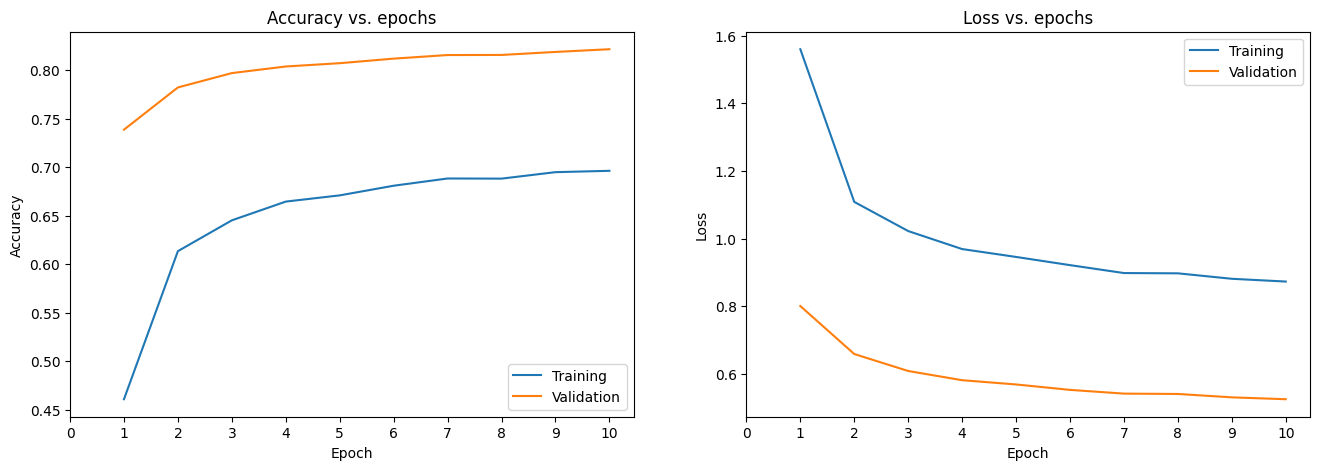

In [38]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [39]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-17 05:22:24,268: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 05:22:24,269: INFO: steps_per_epoch=1562
2022-08-17 05:22:24,270: INFO: start training
2022-08-17 05:22:24,271: INFO: use_class_weight=False


Epoch 1/15
1562/1562 [==============================] - ETA: 0s - loss: 0.7918 - accuracy: 0.7245

2022-08-17 05:26:05,537: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:26:10,836: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 227s 142ms/step - loss: 0.7918 - accuracy: 0.7245 - val_loss: 0.4288 - val_accuracy: 0.8556
Epoch 2/15
1562/1562 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7617

2022-08-17 05:29:55,477: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:30:00,529: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 230s 147ms/step - loss: 0.6839 - accuracy: 0.7617 - val_loss: 0.3821 - val_accuracy: 0.8702
Epoch 3/15
1562/1562 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.7824

2022-08-17 05:32:56,787: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:33:02,231: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 182s 116ms/step - loss: 0.6244 - accuracy: 0.7824 - val_loss: 0.3526 - val_accuracy: 0.8806
Epoch 4/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.5865 - accuracy: 0.7982

2022-08-17 05:34:56,190: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:35:01,062: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 119s 76ms/step - loss: 0.5864 - accuracy: 0.7983 - val_loss: 0.3369 - val_accuracy: 0.8822
Epoch 5/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.5472 - accuracy: 0.8094

2022-08-17 05:36:42,116: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:36:47,005: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 106s 68ms/step - loss: 0.5471 - accuracy: 0.8094 - val_loss: 0.3269 - val_accuracy: 0.8885
Epoch 6/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.5172 - accuracy: 0.8197

2022-08-17 05:38:27,683: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:38:32,498: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 105s 68ms/step - loss: 0.5171 - accuracy: 0.8198 - val_loss: 0.3190 - val_accuracy: 0.8920
Epoch 7/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.4946 - accuracy: 0.8275

2022-08-17 05:40:13,357: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:40:18,641: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 106s 68ms/step - loss: 0.4946 - accuracy: 0.8275 - val_loss: 0.3034 - val_accuracy: 0.8968
Epoch 8/15
1562/1562 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.8369

2022-08-17 05:41:59,293: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:42:04,630: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 106s 68ms/step - loss: 0.4713 - accuracy: 0.8369 - val_loss: 0.3012 - val_accuracy: 0.8998
Epoch 9/15
1562/1562 [==============================] - 83s 53ms/step - loss: 0.4518 - accuracy: 0.8451 - val_loss: 0.3001 - val_accuracy: 0.8987
Epoch 10/15
1562/1562 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.8471

2022-08-17 05:45:09,818: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:45:15,085: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 107s 69ms/step - loss: 0.4417 - accuracy: 0.8471 - val_loss: 0.2817 - val_accuracy: 0.9026
Epoch 11/15
1562/1562 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.8527

2022-08-17 05:47:23,963: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:47:29,069: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 134s 86ms/step - loss: 0.4216 - accuracy: 0.8527 - val_loss: 0.2763 - val_accuracy: 0.9053
Epoch 12/15
1562/1562 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8591

2022-08-17 05:49:46,093: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:49:51,354: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 142s 91ms/step - loss: 0.4095 - accuracy: 0.8591 - val_loss: 0.2726 - val_accuracy: 0.9076
Epoch 13/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.4001 - accuracy: 0.8597

2022-08-17 05:51:38,680: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:51:44,408: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 113s 72ms/step - loss: 0.4002 - accuracy: 0.8597 - val_loss: 0.2671 - val_accuracy: 0.9088
Epoch 14/15
1562/1562 [==============================] - 127s 81ms/step - loss: 0.3874 - accuracy: 0.8639 - val_loss: 0.2725 - val_accuracy: 0.9087
Epoch 15/15
1562/1562 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8682

2022-08-17 05:57:52,393: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 05:57:57,545: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 247s 158ms/step - loss: 0.3746 - accuracy: 0.8682 - val_loss: 0.2631 - val_accuracy: 0.9113


2022-08-17 05:57:58,757: INFO: finish training [elapsed time: 2134.49 seconds]


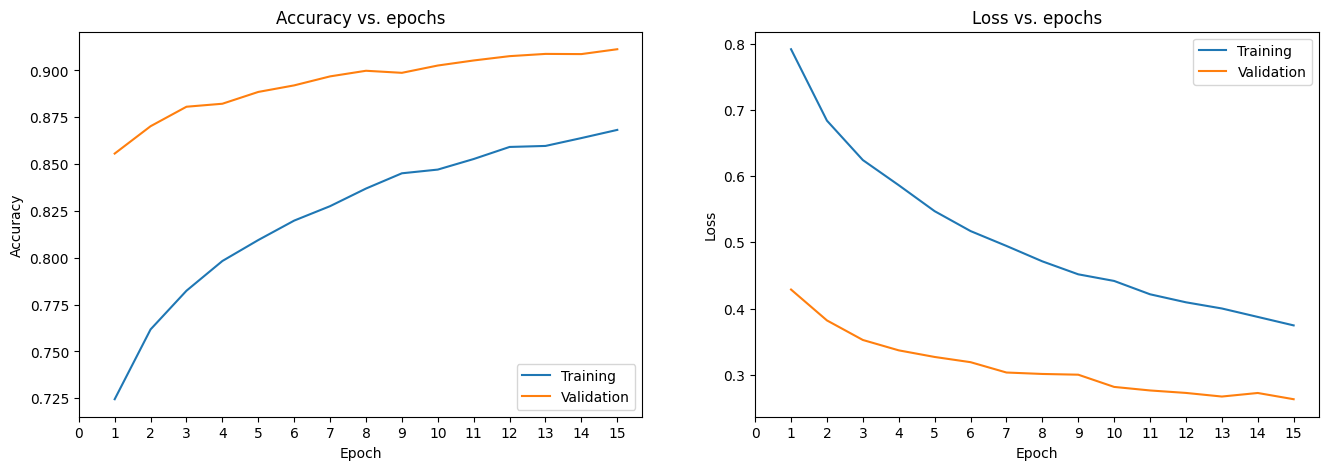

2022-08-17 05:57:59,174: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 6s 20ms/step


2022-08-17 06:00:10,218: INFO: test loss:0.2631
2022-08-17 06:00:10,219: INFO: test accuracy:0.9113
2022-08-17 06:00:10,223: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/results.json


----------------------------------------save model results and generator----------------------------------------


2022-08-17 06:00:10,224: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/results.json
2022-08-17 06:00:10,225: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/default.generator
2022-08-17 06:00:10,227: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/default.generator


----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 7s 23ms/step


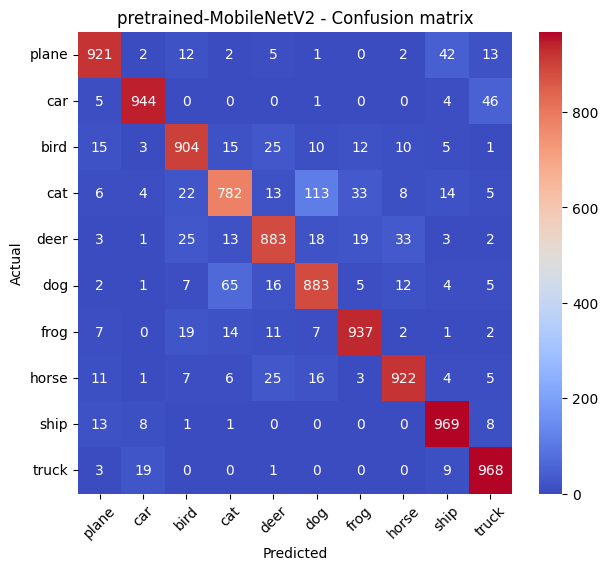

----------------------------------------models----------------------------------------


model_name                     program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_5000_aug.ipynb        1874250   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1      2134.5  2022-08-17 06:00      0.1945     0.2631          0.9328   

   test_accuracy  train_auc  test_auc  
1         0.9113     0.9973    0.9952

In [40]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

2022-08-17 06:02:13,398: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 06:02:13,399: INFO: steps_per_epoch=1562
2022-08-17 06:02:13,399: INFO: start training
2022-08-17 06:02:13,400: INFO: use_class_weight=False


Epoch 1/10
1562/1562 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.8712

2022-08-17 06:05:51,967: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 06:05:57,052: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 224s 144ms/step - loss: 0.3700 - accuracy: 0.8712 - val_loss: 0.2630 - val_accuracy: 0.9120
Epoch 2/10
1562/1562 [==============================] - 231s 148ms/step - loss: 0.3593 - accuracy: 0.8749 - val_loss: 0.2609 - val_accuracy: 0.9103
Epoch 3/10
1562/1562 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8785

2022-08-17 06:12:54,273: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 06:13:00,841: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 192s 123ms/step - loss: 0.3513 - accuracy: 0.8785 - val_loss: 0.2599 - val_accuracy: 0.9134
Epoch 4/10
1562/1562 [==============================] - 133s 85ms/step - loss: 0.3454 - accuracy: 0.8784 - val_loss: 0.2672 - val_accuracy: 0.9132
Epoch 5/10
1562/1562 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8823

2022-08-17 06:17:01,484: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 06:17:06,745: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 113s 72ms/step - loss: 0.3354 - accuracy: 0.8823 - val_loss: 0.2576 - val_accuracy: 0.9162
Epoch 6/10
1562/1562 [==============================] - 89s 57ms/step - loss: 0.3263 - accuracy: 0.8865 - val_loss: 0.2570 - val_accuracy: 0.9146
Epoch 7/10
1562/1562 [==============================] - 114s 73ms/step - loss: 0.3218 - accuracy: 0.8881 - val_loss: 0.2512 - val_accuracy: 0.9146
Epoch 8/10
1562/1562 [==============================] - 87s 56ms/step - loss: 0.3151 - accuracy: 0.8884 - val_loss: 0.2605 - val_accuracy: 0.9145
Epoch 9/10
1562/1562 [==============================] - 110s 71ms/step - loss: 0.3077 - accuracy: 0.8924 - val_loss: 0.2552 - val_accuracy: 0.9151
Epoch 10/10
1562/1562 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8960

2022-08-17 06:27:24,526: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


2022-08-17 06:27:29,594: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 223s 143ms/step - loss: 0.3015 - accuracy: 0.8960 - val_loss: 0.2510 - val_accuracy: 0.9199


2022-08-17 06:27:30,378: INFO: finish training [elapsed time: 1516.98 seconds]


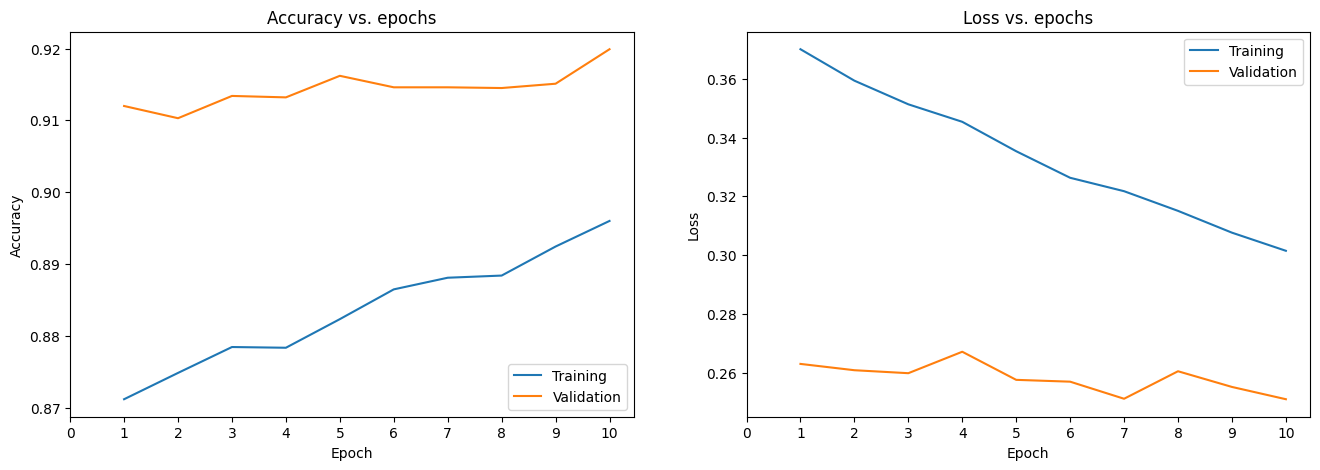

2022-08-17 06:27:30,741: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 6s 20ms/step


2022-08-17 06:29:28,719: INFO: test loss:0.2510
2022-08-17 06:29:28,720: INFO: test accuracy:0.9199
2022-08-17 06:29:28,723: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/results.json
2022-08-17 06:29:28,725: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/results.json
2022-08-17 06:29:28,726: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/default.generator
2022-08-17 06:29:28,727: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 9s 30ms/step


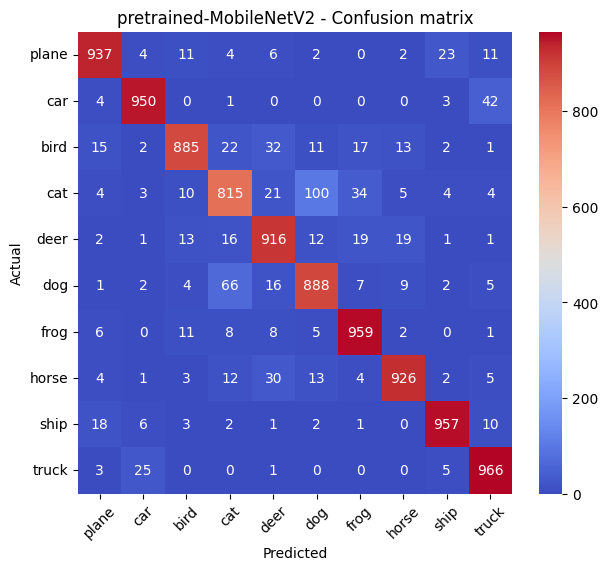

----------------------------------------models----------------------------------------


model_name                     program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_5000_aug.ipynb        1874250   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1      1517.0  2022-08-17 06:29       0.154      0.251           0.947   

   test_accuracy  train_auc  test_auc  
1         0.9199     0.9982    0.9958

In [49]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [12]:
data_model_results = qtf.classification.DataModelResults(paArams.data_path) 
data_model_results.show(20)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:110: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 9.1.1
Pillow version: 9.0.1
  warnings.warn(str(v), RuntimeWarning)
[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.8/dist-packages/PIL/Image.py", line 92, in <module>
    raise ImportError(
I

NameError: name 'paArams' is not defined

In [42]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-17 06:00:18,569: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2
2022-08-17 06:00:29,211: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator
2022-08-17 06:00:29,251: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2
2022-08-17 06:00:39,694: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-08-17 06:00:39,732: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2
2022-08-17 06:00:50,990: INFO: load

2022-08-17 06:01:00,463: WARNING: Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2022-08-17 06:01:00,465: WARNING: Value in checkpoint could not be found in the restored object: (root).layer-1.layer-0._random_generator._generator._state_var


2022-08-17 06:01:00,466: WARNING: Value in checkpoint could not be found in the restored object: (root).layer-1.layer-1._random_generator._generator._state_var
2022-08-17 06:01:02,353: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-17 06:01:02,357: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2
2022-08-17 06:01:12,447: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

In [43]:
predictors[0].classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

1/1 [==============================] - 1s 876ms/step


2022-08-17 06:01:16,774: WARNING: 5 out of the last 2193 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fdf8bd7d280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 892ms/step


2022-08-17 06:01:17,722: WARNING: 6 out of the last 2194 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fdf0fddb820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 18ms/step


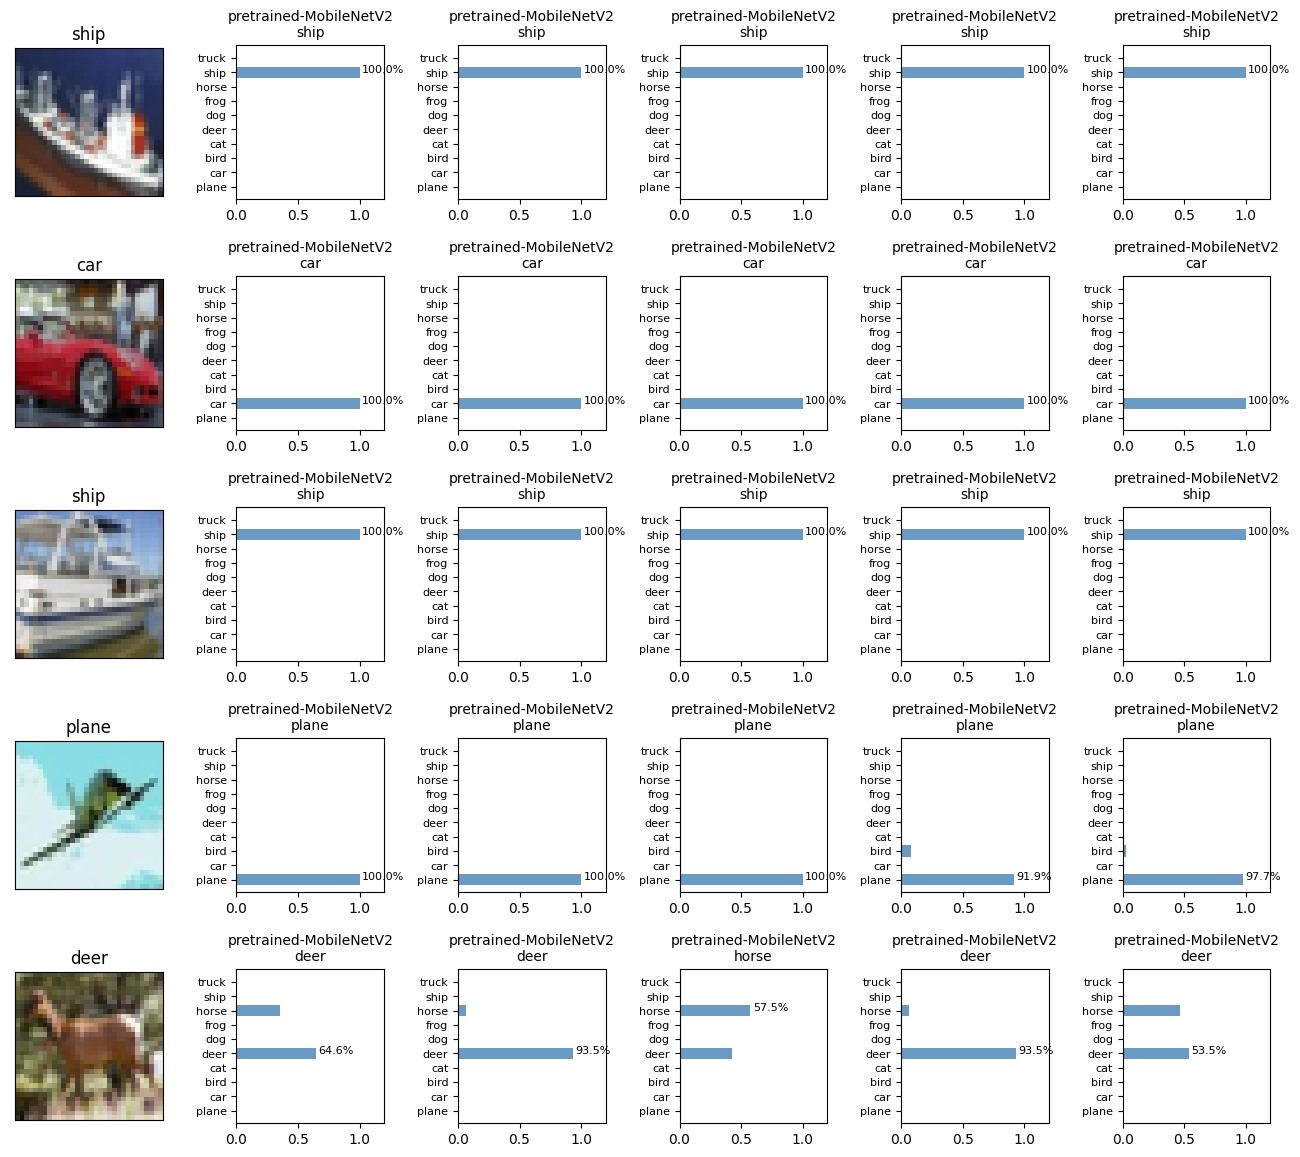

In [44]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                     sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 18ms/step


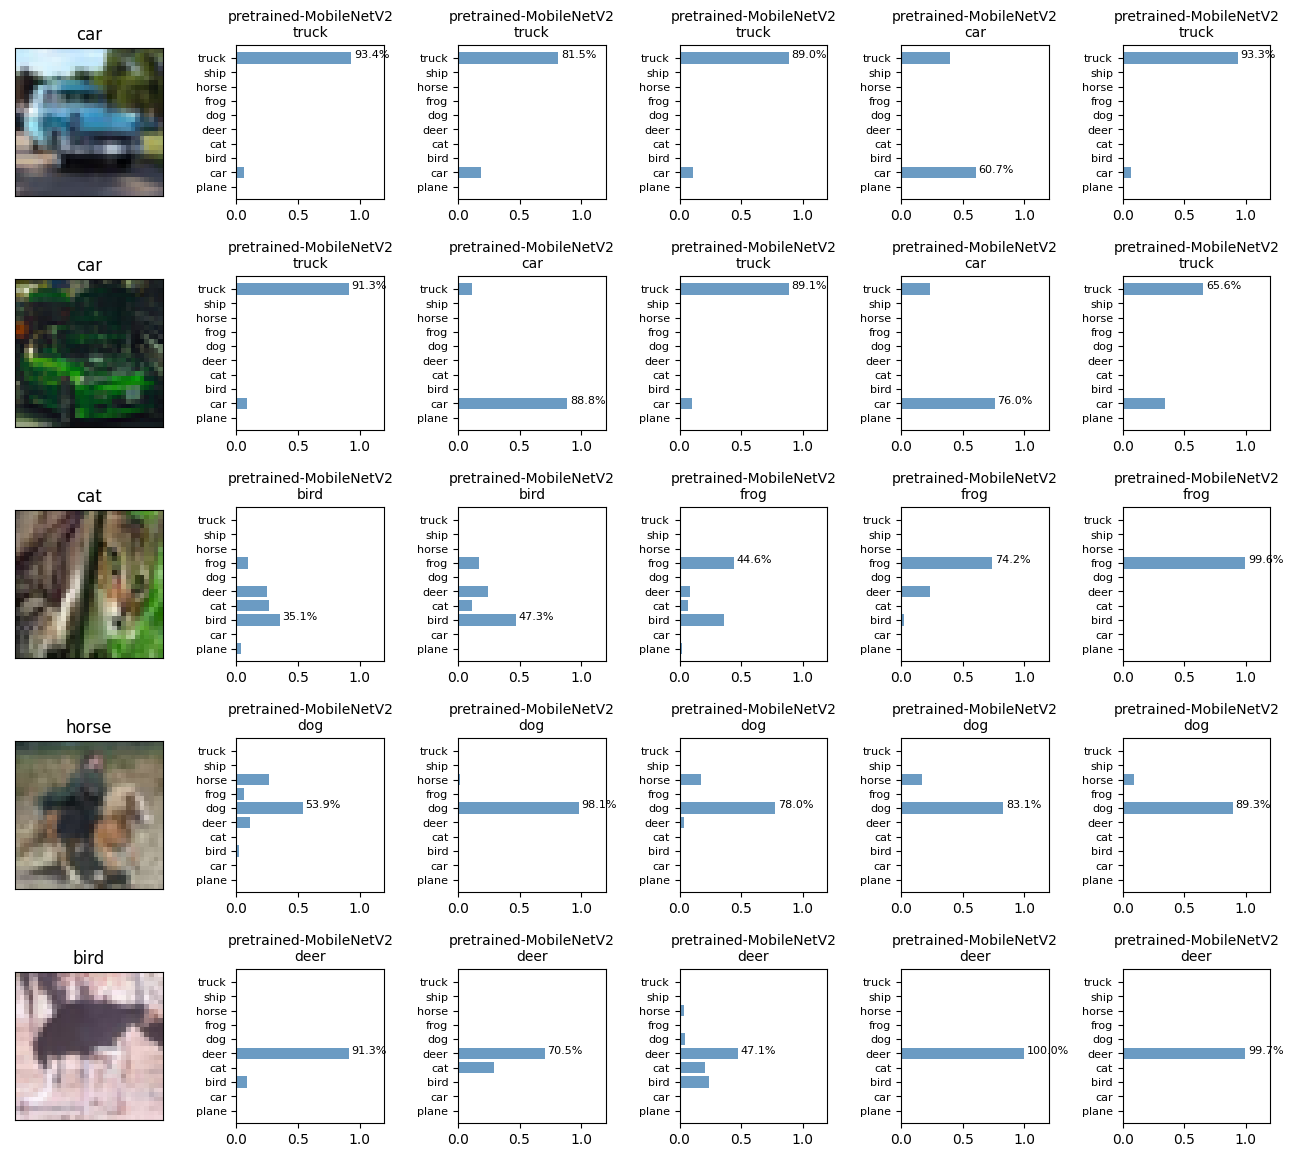

In [45]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [46]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.23238687217235565, 'accuracy': 0.9312000274658203, 'mae': 10.514875411987305}
313/313 [==============================] - 8s 27ms/step
(10000, 10)


In [47]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 10s 33ms/step


precision  recall        f1
plane   0.910462   0.966  0.937409
car     0.978659   0.963  0.970766
bird    0.940268   0.913  0.926433
cat     0.881799   0.843  0.861963
deer    0.892823   0.933  0.912469
dog     0.929806   0.861  0.894081
frog    0.913938   0.977  0.944418
horse   0.952333   0.939  0.945619
ship    0.971282   0.947  0.958987
truck   0.944499   0.970  0.957079

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9105    0.9660    0.9374      1000
         car     0.9787    0.9630    0.9708      1000
        bird     0.9403    0.9130    0.9264      1000
         cat     0.8818    0.8430    0.8620      1000
        deer     0.8928    0.9330    0.9125      1000
         dog     0.9298    0.8610    0.8941      1000
        frog     0.9139    0.9770    0.9444      1000
       horse     0.9523    0.9390    0.9456      1000
        ship     0.9713    0.9470    0.9590      1000
       truck     0.9445    0.9700    0.9571      1000

    accuracy                         0.9312     10000
   macro avg     0.9316    0.9312    0.9309     10000
weighted avg     0.9316    0.9312    0.9309     10000



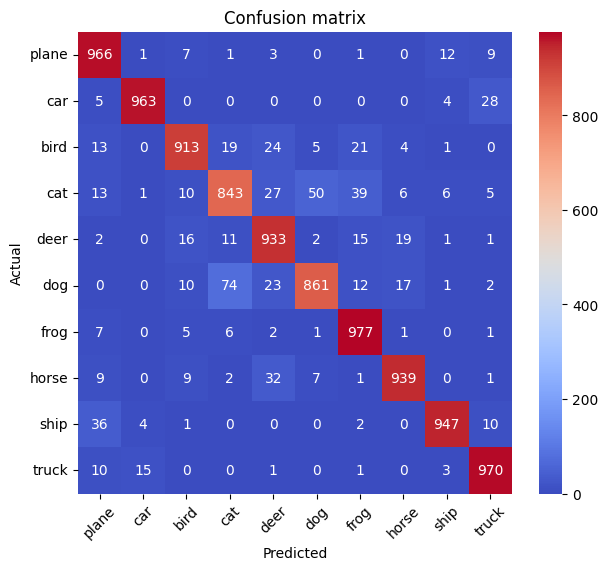

In [48]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)